In [138]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re


base_path = r"C:\Users\chandu\Desktop\masters\masters\columbia\spring2025\AML\project\deliverable2"

aqi_county_df = pd.read_csv(f"{base_path}\\annual_aqi_by_county_2024.csv")
conc_monitor_df = pd.read_csv(f"{base_path}\\annual_conc_by_monitor_2024.csv")


def clean_df(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    return df

aqi_county_df = clean_df(aqi_county_df)
conc_monitor_df = clean_df(conc_monitor_df)


datetime_cols = [col for col in conc_monitor_df.columns if 'DateTime' in col]
for col in datetime_cols:
    conc_monitor_df[col] = pd.to_datetime(conc_monitor_df[col], errors='coerce')


merged_county_monitor = pd.merge(
    aqi_county_df,
    conc_monitor_df,
    left_on=["State", "County", "Year"],
    right_on=["State Name", "County Name", "Year"],
    how="left"
)


print("Merged Data Shape:", merged_county_monitor.shape)
print("Columns in Merged Dataset:\n", merged_county_monitor.columns.tolist())



Merged Data Shape: (58456, 72)
Columns in Merged Dataset:
 ['State', 'County', 'Year', 'Days with AQI', 'Good Days', 'Moderate Days', 'Unhealthy for Sensitive Groups Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI', '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days PM2.5', 'Days PM10', 'State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration', 'Pollutant Standard', 'Metric Used', 'Method Name', 'Units of Measure', 'Event Type', 'Observation Count', 'Observation Percent', 'Completeness Indicator', 'Valid Day Count', 'Required Day Count', 'Exceptional Data Count', 'Null Data Count', 'Primary Exceedance Count', 'Secondary Exceedance Count', 'Certification Indicator', 'Num Obs Below MDL', 'Arithmetic Mean', 'Arithmetic Standard Dev', '1st Max Value', '1st Max DateTime', '2nd Max Value', '2nd Max DateTime', '3rd Max Value', '3rd Max DateTime', '4th Max Value

In [139]:

missing_summary = merged_county_monitor.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(" Columns with Missing Values:\n", missing_summary)


threshold = 0.5 * len(merged_county_monitor)
columns_to_drop = missing_summary[missing_summary > threshold].index.tolist()
merged_county_monitor.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"\nDropped {len(columns_to_drop)} columns with more than 50% missing data.")




num_cols = merged_county_monitor.select_dtypes(include=[np.number]).columns
merged_county_monitor[num_cols] = merged_county_monitor[num_cols].fillna(merged_county_monitor[num_cols].median())

cat_cols = merged_county_monitor.select_dtypes(include=['object']).columns
for col in cat_cols:
    if merged_county_monitor[col].isnull().any():
        merged_county_monitor[col].fillna(merged_county_monitor[col].mode()[0], inplace=True)

print("\nRemaining Missing Values:", merged_county_monitor.isnull().sum().sum())




 Columns with Missing Values:
 1st NO Max DateTime              58229
1st Max Non Overlapping Value    58229
2nd NO Max DateTime              58229
2nd Max Non Overlapping Value    58229
Secondary Exceedance Count       45420
Primary Exceedance Count         44639
Pollutant Standard               37862
Method Name                      12887
City Name                        11980
CBSA Name                         5558
Local Site Name                   4248
10th Percentile                    557
4th Max Value                      285
4th Max DateTime                   285
3rd Max Value                      182
3rd Max DateTime                   182
50th Percentile                    169
2nd Max DateTime                   141
2nd Max Value                      141
75th Percentile                     37
90th Percentile                      8
95th Percentile                      5
99th Percentile                      4
Arithmetic Mean                      4
Arithmetic Standard Dev          

C:\Users\chandu\AppData\Local\Temp\ipykernel_25808\446741937.py:20: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Identifies and drops high-missing-value columns

Fills remaining:

Numerical values with median

Categorical values with mode



In [141]:
merged_county_monitor.dtypes


State                  object
County                 object
Year                    int64
Days with AQI           int64
Good Days               int64
                        ...  
State Name             object
County Name            object
City Name              object
CBSA Name              object
Date of Last Change    object
Length: 65, dtype: object

In [142]:
for col in merged_county_monitor.select_dtypes(include='object').columns:
    print(f"{col}: {merged_county_monitor[col].nunique()} unique values")


State: 54 unique values
County: 767 unique values
Datum: 2 unique values
Parameter Name: 423 unique values
Sample Duration: 12 unique values
Metric Used: 13 unique values
Method Name: 358 unique values
Units of Measure: 27 unique values
Event Type: 4 unique values
Completeness Indicator: 2 unique values
Certification Indicator: 1 unique values
Local Site Name: 2051 unique values
Address: 2212 unique values
State Name: 54 unique values
County Name: 767 unique values
City Name: 1147 unique values
CBSA Name: 498 unique values
Date of Last Change: 148 unique values


In [143]:
merged_county_monitor.isnull().sum().sum()


608

In [144]:
missing_cols = merged_county_monitor.isnull().sum()
missing_cols = missing_cols[missing_cols > 0].sort_values(ascending=False)
print(missing_cols)


4th Max DateTime    285
3rd Max DateTime    182
2nd Max DateTime    141
dtype: int64


In [145]:
merged_county_monitor.drop(columns=["2nd Max DateTime", "3rd Max DateTime", "4th Max DateTime"], inplace=True)


dropping columns as we are not focusing on time series analysis

In [147]:
merged_county_monitor.isnull().sum().sum()


0

In [148]:

merged_county_monitor.describe()


,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Observation Count,Observation Percent,Valid Day Count,Required Day Count,Exceptional Data Count,Null Data Count,Num Obs Below MDL,Arithmetic Mean,Arithmetic Standard Dev,1st Max Value,1st Max DateTime,2nd Max Value,3rd Max Value,4th Max Value,99th Percentile,98th Percentile,95th Percentile,90th Percentile,75th Percentile,50th Percentile,10th Percentile
count,58456.0,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.0,58456.000000,58456.000000,58456.000000,58456,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000,58456.000000
mean,2024.0,227.775113,136.811722,83.167836,5.868243,1.520203,0.331138,0.075972,138.760264,69.904236,45.344721,0.931897,2.552364,117.970131,100.582387,5.738333,28.050636,72.857500,1191.453196,70068.750907,3.240848,38.634404,-95.746949,1842.233748,46.353172,103.389866,205.643647,20.237666,66.262847,0.0,31.592681,6.486276,69.318276,2024-03-25 08:42:06.104078080,62.822720,59.214049,57.223943,50.368400,47.367498,43.068198,39.780928,34.729905,30.602495,24.881868
min,2024.0,10.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,11101.000000,1.000000,17.955378,-160.508331,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,-8.786395,0.000000,-0.000940,2024-01-01 00:00:00,-0.100000,-0.400000,-1.800000,-0.100000,-0.600000,-0.900000,-1.400000,-2.100000,-8.100000,-42.000000
25%,2024.0,183.000000,100.000000,40.000000,0.000000,0.000000,0.000000,0.000000,93.000000,57.000000,39.000000,0.000000,0.000000,69.000000,52.000000,0.000000,12.000000,20.000000,8.000000,44201.000000,1.000000,35.007146,-111.713611,26.000000,34.000000,25.000000,61.000000,0.000000,0.000000,0.0,0.042327,0.011463,0.080000,2024-01-21 00:00:00,0.070000,0.066000,0.064000,0.074000,0.070000,0.064000,0.058000,0.049000,0.033860,0.001000
50%,2024.0,244.000000,141.000000,80.000000,2.000000,0.000000,0.000000,0.000000,119.000000,64.000000,45.000000,0.000000,0.000000,118.000000,90.000000,0.000000,28.000000,49.000000,33.000000,88101.000000,2.000000,39.521933,-91.179219,51.000000,47.000000,51.000000,122.000000,0.000000,1.000000,0.0,0.596537,0.417615,2.770000,2024-02-28 19:00:00,2.000000,1.700000,1.522000,2.159300,2.000000,1.481410,1.100000,0.730000,0.454000,0.164000
75%,2024.0,274.000000,176.000000,119.000000,6.000000,1.000000,0.000000,0.000000,156.000000,74.000000,52.000000,1.000000,2.000000,163.000000,140.000000,3.000000,42.000000,97.000000,1009.000000,88113.000000,5.000000,41.782370,-81.633981,2542.500000,58.000000,181.000000,366.000000,0.000000,6.000000,0.0,7.083882,3.882564,26.300000,2024-05-25 13:00:00,21.500000,19.300000,18.100000,20.900000,17.900000,14.500000,12.000000,8.900000,6.100000,2.900000
max,2024.0,306.000000,295.000000,238.000000,54.000000,43.000000,21.000000,4.000000,1322.000000,187.000000,87.000000,214.000000,181.000000,305.000000,305.000000,274.000000,80.000000,810.000000,9997.000000,88503.000000,81.000000,68.637233,-64.795972,103776.000000,100.000000,306.000000,366.000000,67071.000000,48047.000000,0.0,31165.071330,23477.621992,210878.000000,2024-10-31 12:00:00,205489.000000,175023.000000,172593.000000,107526.000000,95474.000000,76515.000000,63496.000000,43890.000000,26150.000000,7394.000000
std,0.0,62.368776,56.408441,51.594434,10.340475,5.783542,1.806067,0.468047,113.703624

In [149]:
merged_county_monitor = merged_county_monitor.drop_duplicates(subset=["State", "County", "Year"])
print("New shape after dropping duplicates:", merged_county_monitor.shape)


New shape after dropping duplicates: (986, 62)


In [150]:

merged_county_monitor[['State', 'County', 'Max AQI']].sort_values(by='Max AQI', ascending=False).head(10)


,State,County,Max AQI
5041,California,Inyo,1322
34172,New Mexico,Dona Ana,692
3094,Arizona,Santa Cruz,494
33850,New Mexico,Bernalillo,443
48535,Texas,El Paso,431
54467,Washington,King,354
789,Alaska,Fairbanks North Star,325
1363,Arizona,Cochise,307
3011,Arizona,Pinal,289
41284,Oklahoma,Ottawa,288


In [151]:
merged_county_monitor['Max AQI'] = merged_county_monitor['Max AQI'].clip(upper=500)


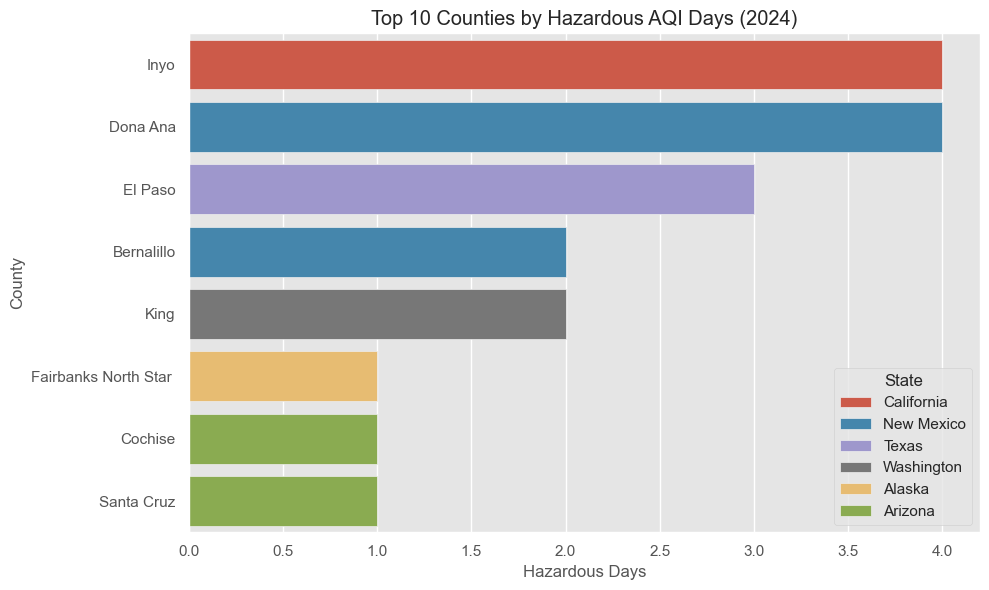

In [152]:
top_hazardous = merged_county_monitor[merged_county_monitor['Hazardous Days'] > 0]
top_hazardous = top_hazardous[['State', 'County', 'Hazardous Days']].sort_values(by='Hazardous Days', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='Hazardous Days', y='County', data=top_hazardous, hue='State')
plt.title("Top 10 Counties by Hazardous AQI Days (2024)")
plt.tight_layout()
plt.show()


Only a small number of counties experience hazardous air quality, but those that do—especially in states like Inyo, Dona ana, El Paso—face dangerously high short-term exposure that could elevate cancer and respiratory risks

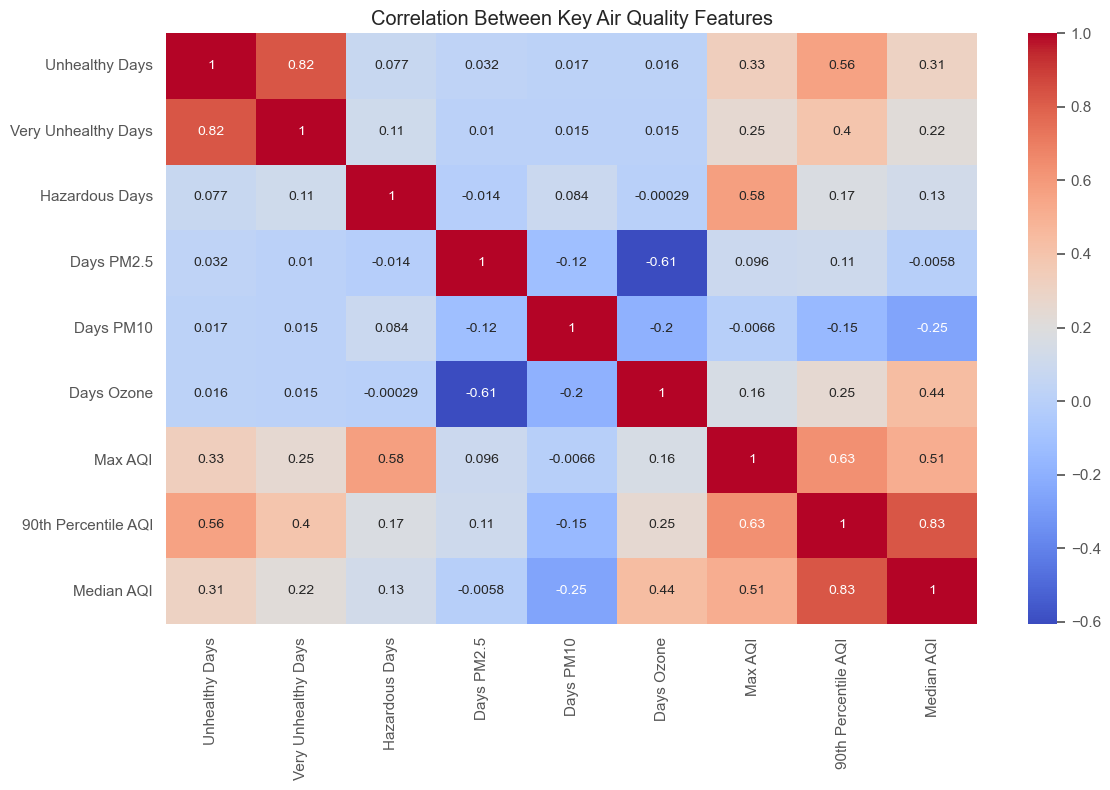

In [154]:
core_columns = ['Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Days PM2.5', 'Days PM10', 'Days Ozone', 'Max AQI', '90th Percentile AQI', 'Median AQI']
plt.figure(figsize=(12,8))
sns.heatmap(merged_county_monitor[core_columns].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Key Air Quality Features")
plt.tight_layout()
plt.show()


Very Unhealthy Days and Unhealthy Days are highly correlated, as expected. PM2.5 and Max AQI show moderate correlation, reinforcing PM2.5’s role in severe air quality events. 

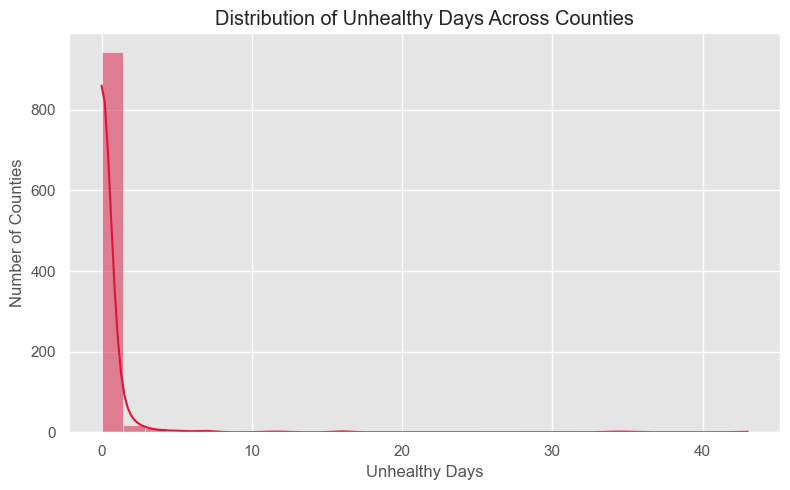

In [156]:
plt.figure(figsize=(8,5))
sns.histplot(merged_county_monitor['Unhealthy Days'], bins=30, kde=True, color='crimson')
plt.title("Distribution of Unhealthy Days Across Counties")
plt.xlabel("Unhealthy Days")
plt.ylabel("Number of Counties")
plt.tight_layout()
plt.show()


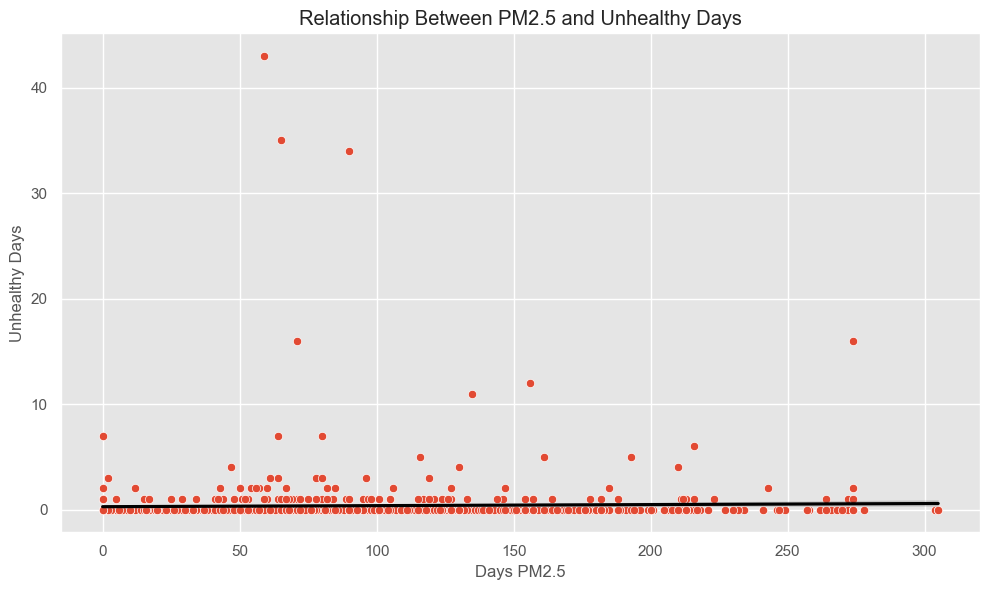

In [157]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Days PM2.5', y='Unhealthy Days', data=merged_county_monitor)
sns.regplot(x='Days PM2.5', y='Unhealthy Days', data=merged_county_monitor, scatter=False, color='black')
plt.title("Relationship Between PM2.5 and Unhealthy Days")
plt.tight_layout()
plt.show()


In [158]:
import plotly.express as px

px.scatter_geo(
    merged_county_monitor,
    lat='Latitude',
    lon='Longitude',
    color='Days PM2.5',
    size='Days PM2.5',
    scope='usa',
    hover_name='County',
    title='PM2.5 Exposure by County (2024)'
)


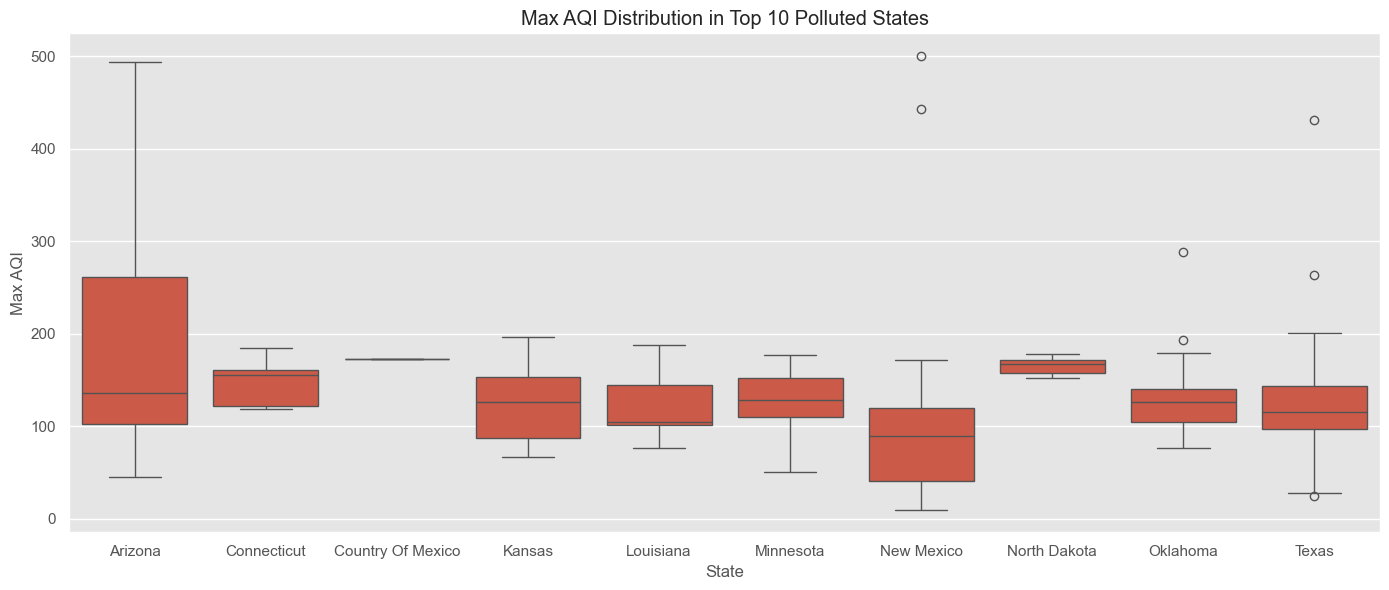

In [159]:
top_states = merged_county_monitor.groupby('State')['Max AQI'].mean().sort_values(ascending=False).head(10).index
plt.figure(figsize=(14,6))
sns.boxplot(x='State', y='Max AQI', data=merged_county_monitor[merged_county_monitor['State'].isin(top_states)])
plt.title("Max AQI Distribution in Top 10 Polluted States")
plt.tight_layout()
plt.show()


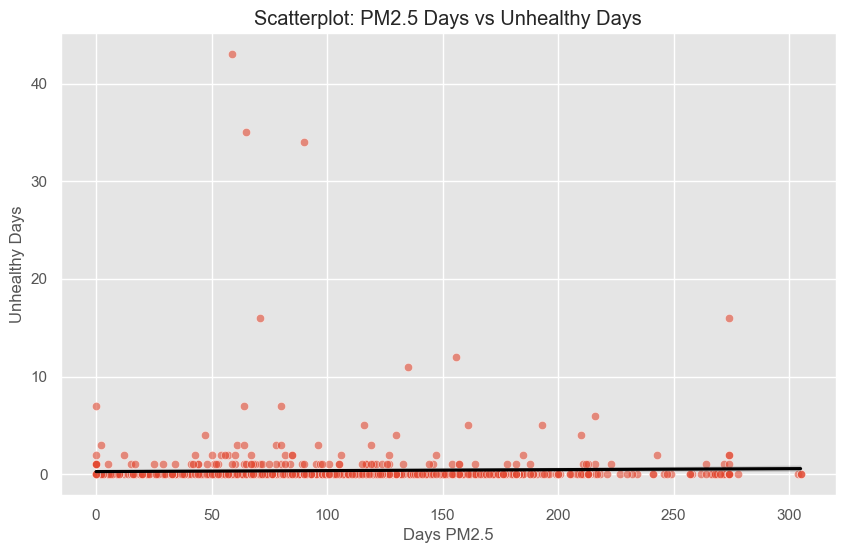

In [160]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Days PM2.5', y='Unhealthy Days', data=merged_county_monitor, alpha=0.6)
sns.regplot(x='Days PM2.5', y='Unhealthy Days', data=merged_county_monitor, scatter=False, color='black')
plt.title("Scatterplot: PM2.5 Days vs Unhealthy Days")
plt.show()


In [161]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

le_state = LabelEncoder()
le_county = LabelEncoder()

merged_county_monitor['State_encoded'] = le_state.fit_transform(merged_county_monitor['State'])
merged_county_monitor['County_encoded'] = le_county.fit_transform(merged_county_monitor['County'])

pollutant_features = ['Days PM2.5', 'Days PM10', 'Days Ozone', 'Unhealthy Days', 'Max AQI']


scaler = StandardScaler()
pollutant_scaled = scaler.fit_transform(merged_county_monitor[pollutant_features])

pollutant_scaled_df = pd.DataFrame(pollutant_scaled, columns=[f"{col}_scaled" for col in pollutant_features])


merged_county_monitor = pd.concat([merged_county_monitor.reset_index(drop=True), pollutant_scaled_df.reset_index(drop=True)], axis=1)


print("Scaled + Encoded Dataset Preview:")
print(merged_county_monitor.head())


Scaled + Encoded Dataset Preview:
     State   County  Year  Days with AQI  Good Days  Moderate Days  Unhealthy for Sensitive Groups Days  Unhealthy Days  Very Unhealthy Days  Hazardous Days  Max AQI  90th Percentile AQI  Median AQI  Days CO  Days NO2  Days Ozone  Days PM2.5  Days PM10  State Code  County Code  Site Num  Parameter Code  POC   Latitude  Longitude  Datum            Parameter Name Sample Duration                                        Metric Used                                        Method Name             Units of Measure Event Type  Observation Count  Observation Percent Completeness Indicator  Valid Day Count  Required Day Count  Exceptional Data Count  Null Data Count     Certification Indicator  Num Obs Below MDL  Arithmetic Mean  Arithmetic Standard Dev  1st Max Value    1st Max DateTime  2nd Max Value  3rd Max Value  4th Max Value  99th Percentile  98th Percentile  95th Percentile  90th Percentile  75th Percentile  50th Percentile  10th Percentile                